In [48]:
!pip install chardet
!pip install geopandas
!pip install mapclassify

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import mapclassify
import csv
import chardet
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [5]:
# 2022-2023 대여소별 따릉이 이용 데이터 병합

file1 = '대여소별 이용정보-2207-2212.csv'
file2 = '대여소별 이용정보-2301-2306.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df = pd.concat([df1, df2], ignore_index=True)
df.to_csv('대여소별_따릉이_이용데이터.csv', index=False)

<ipython-input-19-9a5bbf421c93>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped_total = df.groupby('자치구')['대여건수', '반납건수'].sum().reset_index()


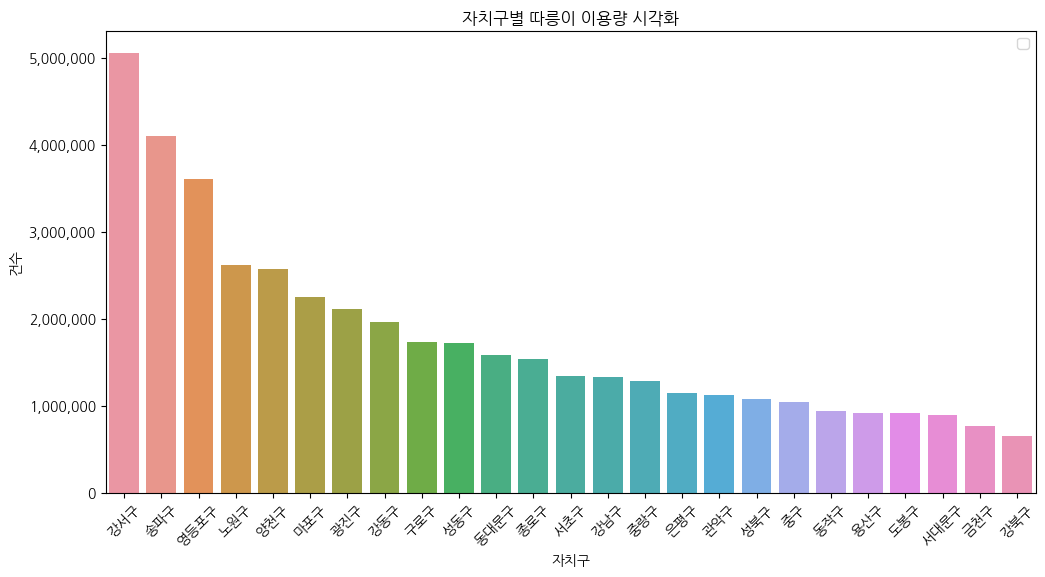

In [19]:
df = pd.read_csv('대여소별_따릉이_이용데이터.csv')
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['기준년월'] = df['기준년월'].dt.strftime('%Y-%m')

# 대여건수 및 반납건수의 숫자 추출 후 숫자로 변환
df['대여건수'] = pd.to_numeric(df['대여건수'].str.replace(',', ''), errors='coerce')
df['반납건수'] = pd.to_numeric(df['반납건수'].str.replace(',', ''), errors='coerce')

# 자치구별 대여건수와 반납건수 총합
df_grouped_total = df.groupby('자치구')['대여건수', '반납건수'].sum().reset_index()

# 대여건수와 반납건수 열의 데이터 타입을 정수로 변환
df_grouped_total['대여건수'] = df_grouped_total['대여건수'].astype(int)
df_grouped_total['반납건수'] = df_grouped_total['반납건수'].astype(int)

# 대여건수를 기준으로 내림차순 정렬
df_grouped_total = df_grouped_total.sort_values(by='대여건수', ascending=False)

# 시각화
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(12, 6))
sns.barplot(x='자치구', y='대여건수', data=df_grouped_total)
sns.barplot(x='자치구', y='반납건수', data=df_grouped_total)
plt.title('자치구별 따릉이 이용량 시각화')
plt.xlabel('자치구')
plt.ylabel('건수')
plt.xticks(rotation=45)

def format_fn(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_fn))
plt.legend()
plt.show()

Index(['ADM_SECT_C', '자치구', 'SGG_OID', 'COL_ADM_SE', 'GID', 'geometry'], dtype='object')
Index(['ADM_SECT_C', '자치구', 'SGG_OID', 'COL_ADM_SE', 'GID', 'geometry',
       '대여건수'],
      dtype='object')


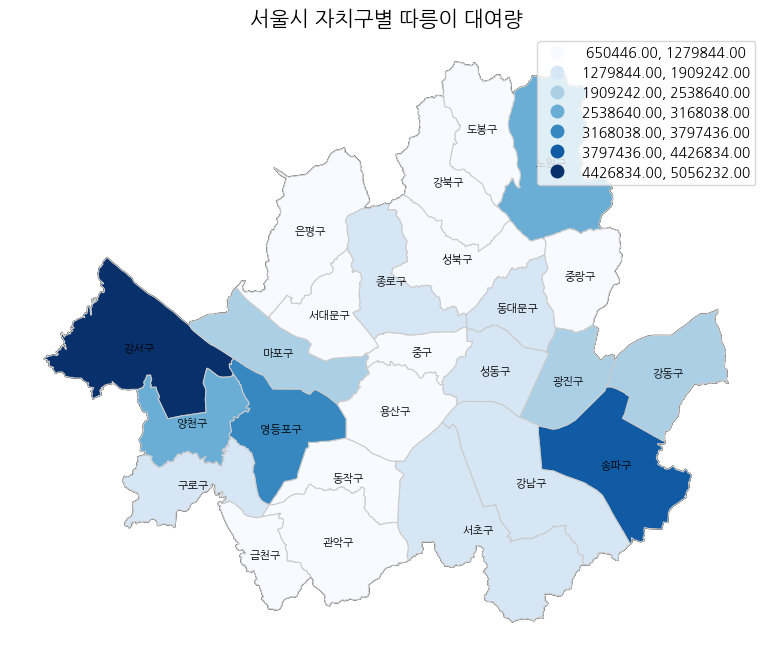

In [150]:
seoul_gdf = gpd.GeoDataFrame.from_file('LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
seoul_gdf = seoul_gdf.rename(columns={'SGG_NM': '자치구'})
print(seoul_gdf.columns)

df_for_map = df_grouped_total[['자치구', '대여건수']]

merged_data = seoul_gdf.merge(df_for_map, on='자치구', how='left')
print(merged_data.columns)

# 단계 구분도를 지도에 적용
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
seoul_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
merged_data.plot(column='대여건수', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, scheme='equal_interval', classification_kwds=dict(k=7))
ax.set_title('서울시 자치구별 따릉이 대여량', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.axis('off')

# 각 자치구에 레이블 추가
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['자치구']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')

plt.show()

     자치구  대여소개수
0    강남구    171
1    강동구    122
2    강북구     61
3    강서구    189
4    관악구     79
5    광진구     86
6    구로구    114
7    금천구     76
8    노원구    136
9    도봉구     76
10  동대문구     84
11   동작구     74
12   마포구    120
13  서대문구     81
14   서초구    148
15   성동구     92
16   성북구     82
17   송파구    218
18   양천구    112
19  영등포구    155
20   용산구     91
21   은평구     98
22   종로구    103
23    중구     88
24   중랑구     93


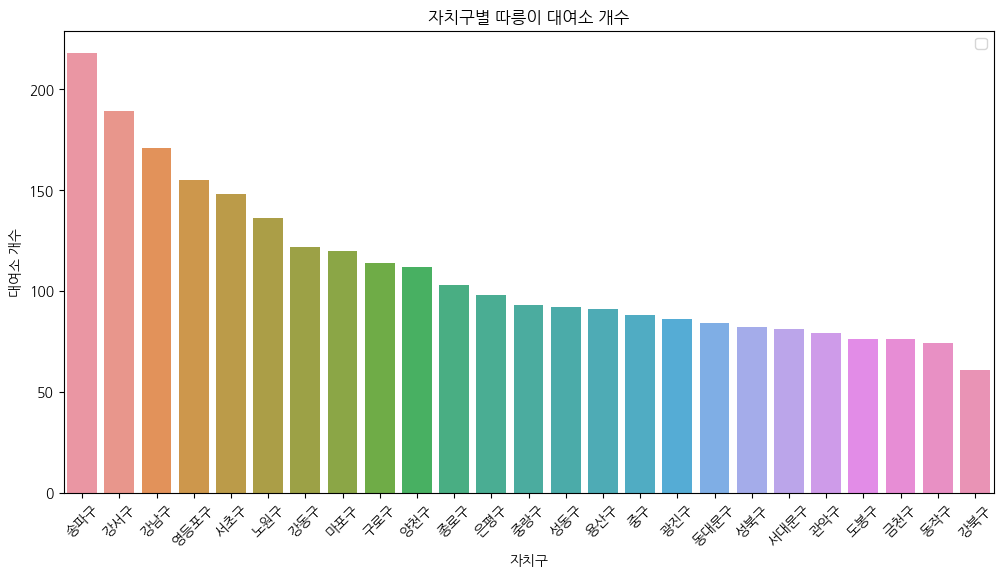

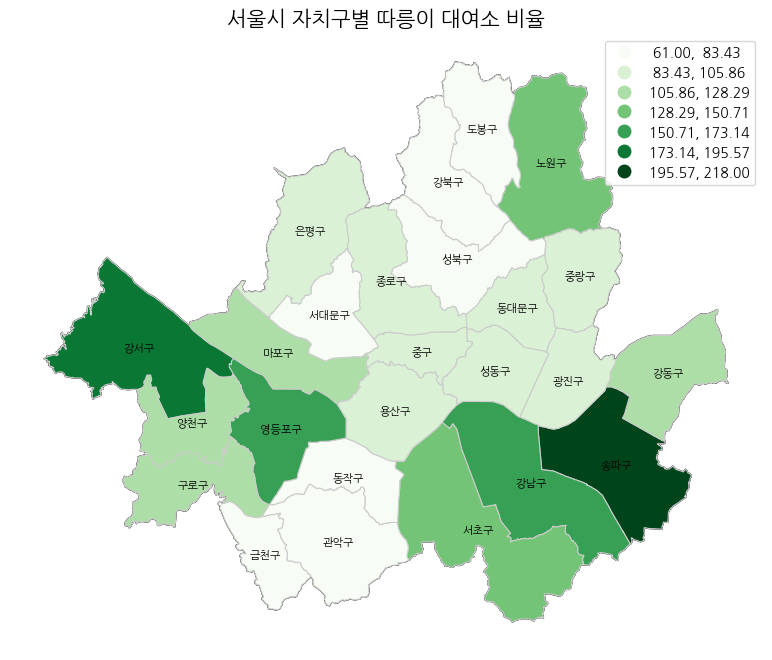

In [154]:
data = pd.read_csv('공공자전거_대여소_정보.csv')
df = pd.DataFrame(data)
df['설치형태1'].fillna(df['설치형태2'], inplace=True)
df.rename(columns={'설치형태1': '설치형태'}, inplace=True)


counts_per_district = df.groupby('자치구').size().reset_index(name='대여소개수')
merged_data = seoul_gdf.merge(counts_per_district, on='자치구', how='left')

print(counts_per_district)

counts_per_district = counts_per_district.sort_values(by='대여소개수', ascending=False)

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(12, 6))
sns.barplot(x='자치구', y='대여소개수', data=counts_per_district)
plt.title('자치구별 따릉이 대여소 개수')
plt.xlabel('자치구')
plt.ylabel('대여소 개수')
plt.xticks(rotation=45)

def format_fn(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_fn))
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
seoul_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
merged_data.plot(column='대여소개수', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, scheme='equal_interval', classification_kwds=dict(k=7))
ax.set_title('서울시 자치구별 따릉이 대여소 비율', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.axis('off')

for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['자치구']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')

plt.show()

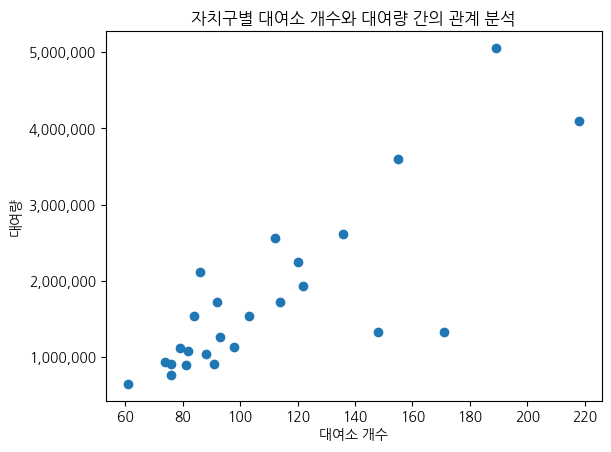

In [164]:
# 자치구별 대여소 개수와 대여량 간의 관계 분석

df = df_for_map.merge(counts_per_district, on='자치구', how='left')

# 산점도 그리기
plt.scatter(df['대여소개수'], df['대여건수'])
plt.title('자치구별 대여소 개수와 대여량 간의 관계 분석')
plt.xlabel('대여소 개수')
plt.ylabel('대여량')

def format_fn(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_fn))
plt.show()

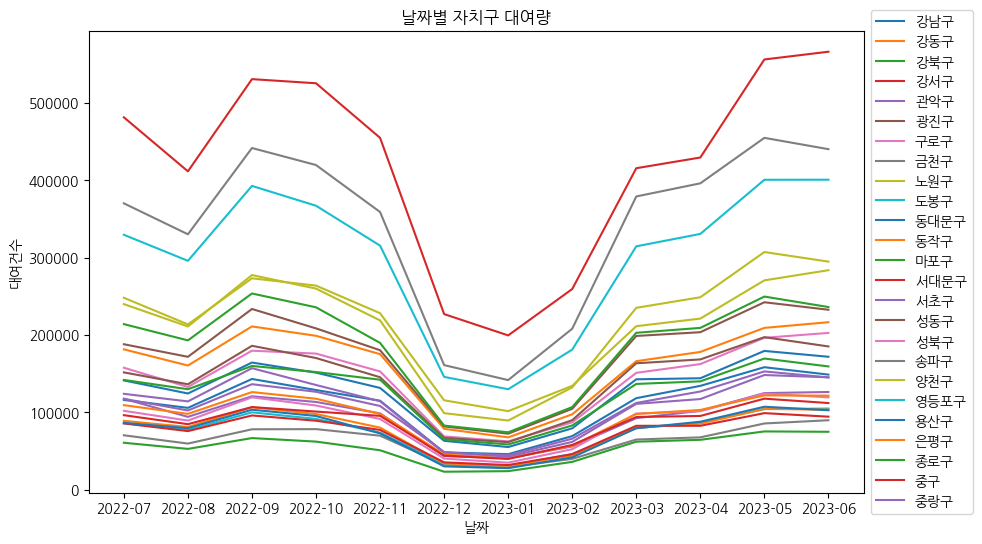

In [174]:
df = pd.read_csv('대여소별_따릉이_이용데이터.csv')
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['기준년월'] = df['기준년월'].dt.strftime('%Y-%m')

df['대여건수'] = pd.to_numeric(df['대여건수'].str.replace(',', ''), errors='coerce')
df['반납건수'] = pd.to_numeric(df['반납건수'].str.replace(',', ''), errors='coerce')

# 날짜별 자치구 대여량을 그룹화하여 시각화
grouped = df.groupby(['기준년월', '자치구'])['대여건수'].sum().reset_index()

plt.figure(figsize=(10, 6))

for district in grouped['자치구'].unique():
    temp_data = grouped[grouped['자치구'] == district]
    plt.plot(temp_data['기준년월'], temp_data['대여건수'], label=district)

plt.title('날짜별 자치구 대여량')
plt.xlabel('날짜')
plt.ylabel('대여건수')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### 특정 대여소에서 자전거가 대여된 경우, 대부분 해당 지역에서 반납되는 경향

- 상관 관계가 0.99로 매우 높음
- 대여건수와 반납건수 간에 강력한 양의 선형 관계
- 이러한 높은 상관 관계는 특정 지역의 주민이 자주 해당 지역에서 자전거를 대여하고 반납하는 패턴이 있을 것으로 예상

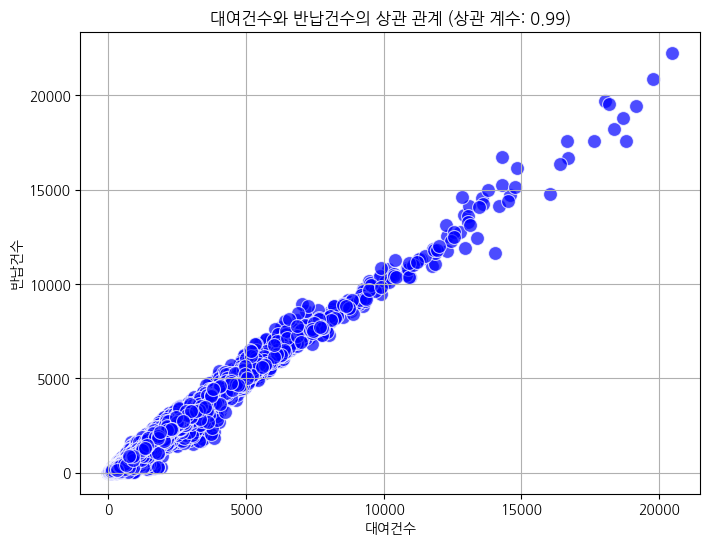

In [176]:
# 대여건수와 반납건수 간의 상관 관계 분석
correlation = df['대여건수'].corr(df['반납건수'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='대여건수', y='반납건수', data=df, s=100, color='blue', alpha=0.7)
plt.title(f'대여건수와 반납건수의 상관 관계 (상관 계수: {correlation:.2f})')
plt.xlabel('대여건수')
plt.ylabel('반납건수')
plt.grid(True)
plt.show()

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing